In [4]:
import pandas as pd
from pyarrow.parquet import ParquetFile
import dask.dataframe as dd
import os
import xarray as xr

#%matplotlib inline


In [5]:
dir_files = [os.path.join("../short_range_18files", files) for files in os.listdir("../short_range_18files")]
#dir_files = [os.path.join("short_range_2files", files) for files in os.listdir("short_range_2files")]
print(dir_files)

['../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f001.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f002.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f003.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f004.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f005.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f006.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f007.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f008.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f009.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f010.conus.nc', '../short_range_18f

In [6]:
fds = []
for f in dir_files:
    fds.append(xr.open_dataset(f))

In [7]:
%%time
ds = xr.concat(fds,dim="time")

CPU times: total: 8.92 s
Wall time: 9.07 s


In [12]:
df = ds.to_dataframe()
df = df.streamflow
df

time                 reference_time  feature_id
2022-09-11 01:00:00  2022-09-11      101           0.18
                                     179           0.01
                                     181           0.01
                                     183           0.01
                                     185           0.01
                                                   ... 
2022-09-11 18:00:00  2022-09-11      1180001800    0.00
                                     1180001801    0.00
                                     1180001802    0.00
                                     1180001803    0.00
                                     1180001804    0.00
Name: streamflow, Length: 49981284, dtype: float64

In [13]:
%%time
df = pd.Series.to_frame(df)

df.to_parquet("../data/parquet_all_feature_ids.gzip"
             , engine="fastparquet" #"pyarrow", "auto"
             , compression="snappy" # "gzip"
            )


CPU times: total: 9.81 s
Wall time: 10 s


In [14]:
ParquetFile("../data/parquet_all_feature_ids.gzip").metadata #  num_columns: 3

  created_by: fastparquet-python version 0.8.3 (build 0)
  num_columns: 4
  num_rows: 49981284
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 1595

CPU times: total: 9.67 s
Wall time: 10.9 s


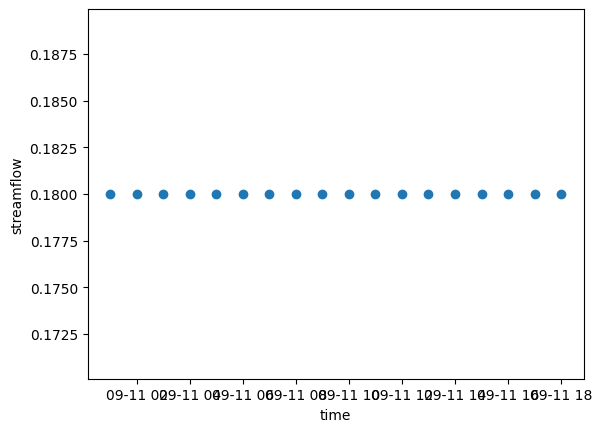

In [15]:
%%time
data = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip"
    , storage_options={"anon": True}
    )
data
result = data.compute()


result = result.loc[:,:, [101]]
#result= result.loc[:, :, 1000:10000]
result
r_xa = result.to_xarray()
r_xa
r_xa.plot.scatter("time","streamflow")